# CP Robust Online Verification Example 6
In this notebook, we showcase examples of CP verification with the robust counterpart (example 6) to accompany the survey paper: "Formal Verification and Control with Conformal Prediction

In [1]:
# Let's first import all necessary modules.
import math
import numpy as np
from numpy import random
from numpy import deg2rad
from numpy import shape
from numpy import array
import matplotlib.pyplot as plt
from aerobench.run_f16_sim import run_f16_sim
from aerobench.visualize import plot
from aerobench.examples.gcas.gcas_autopilot import GcasAutopilot
import matplotlib as mpl
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch
import json
from scipy.stats import gaussian_kde

# Example 6: Robust Predictive Online Verification with Conformal Prediction.

Recall the setup of the simulator from example 5, in which we only considered a single distribution (which we denote by the training distribution). In this example, we consider also a test distribution.

In the test distribution, we sample trajectories with the initial altitude of N(998, 10^2) and with the initial velocity of N(651, 5^2)

In [2]:
# Set a seed.
selected_seed = 100
random.seed(selected_seed)

# Codes for parameters of plotting.
mpl.rcParams.update(mpl.rcParamsDefault)
font = {'size' : 17}
mpl.rc('font', **font)


# Define hyperparameters for the simulation.
power = 9  # engine power level (0-10)
alpha = deg2rad(2.1215)  # Trim Angle of Attack (rad)
beta = 0  # Side slip angle (rad)
phi = -math.pi / 8  # Roll angle from wings level (rad)
theta = (-math.pi / 2) * 0.3  # Pitch angle from nose level (rad)
psi = 0  # Yaw angle from North (rad)
tmax = 5  # simulation time
simulation_step = 1 / 30

# distributional information.
nominal_alt_mean = 1000
nominal_alt_std = 10
nominal_vel_mean = 650
nominal_vel_std = 5
# Newly added information for the disturbed (test) distribution.
disturbed_alt_mean = 998
disturbed_alt_std = 10
disturbed_vel_mean = 651
disturbed_vel_std = 5


# Write a class for simulation purpose.
class Plane:
    def __init__(self, power, alpha, beta, phi, theta, psi, tmax, step, nominal_alt_mean, nominal_alt_std, nominal_vel_mean, nominal_vel_std, disturbed_alt_mean, disturbed_alt_std, disturbed_vel_mean, disturbed_vel_std):
        # This function initializes the system.
        self.power = power # engine power level (0 - 10)
        self.alpha = alpha # Trim Angle of Attack (rad)
        self.beta = beta # Side slip angle (rad)
        self.phi = phi # Roll angle from wings level (rad)
        self.theta = theta # Pitch angle from nose level (rad)
        self.psi = psi # Yaw angle from North (rad)
        self.tmax = tmax
        self.step = step
        
        # Distributional info.
        self.nominal_alt_mean = nominal_alt_mean
        self.nominal_alt_std = nominal_alt_std
        self.nominal_vel_mean = nominal_vel_mean
        self.nominal_vel_std = nominal_vel_std
        self.disturbed_alt_mean = disturbed_alt_mean
        self.disturbed_alt_std = disturbed_alt_std
        self.disturbed_vel_mean = disturbed_vel_mean
        self.disturbed_vel_std = disturbed_vel_std
        
    def generate_nominal_trajectory(self, tmax, step):
        # First, randomly select an initial altitude based on the distribution info.
        alt = random.normal(self.nominal_alt_mean, self.nominal_alt_std)
        vel = random.normal(self.nominal_vel_mean, self.nominal_vel_std)
        init_state = [vel, self.alpha, self.beta, self.phi, self.theta, self.psi, 0, 0, 0, 0, 0, alt, self.power]
        ap = GcasAutopilot(init_mode='roll', stdout=True, gain_str='old')
        res = run_f16_sim(init_state, tmax, ap, step=step, extended_states=True)
        altitude =  list(plot.return_single(res, 'alt')[1])
        velocity = list(plot.return_single(res, 'vt')[1])
        return altitude, velocity
    
    def generate_disturbed_trajectory(self, tmax, step):
        alt = random.normal(self.disturbed_alt_mean, self.disturbed_alt_std)
        vel = random.normal(self.disturbed_vel_mean, self.disturbed_vel_std)
        init_state = [vel, self.alpha, self.beta, self.phi, self.theta, self.psi, 0, 0, 0, 0, 0, alt, self.power]
        ap = GcasAutopilot(init_mode='roll', stdout=True, gain_str='old')
        res = run_f16_sim(init_state, tmax, ap, step=step, extended_states=True)
        altitude =  list(plot.return_single(res, 'alt')[1])
        velocity = list(plot.return_single(res, 'vt')[1])
        return altitude, velocity

Let's use the predictor trained on the nominal distribution in example 5, and illustrate its predictions on 3 trajectories from the disturbed (test) distribution.

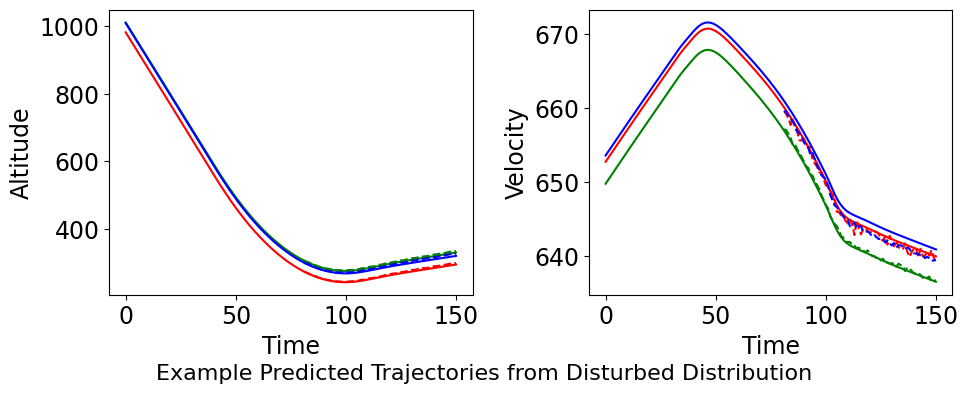

In [3]:
# Generate ground truth illustration trajectories.
plane = Plane(power, alpha, beta, phi, theta, psi, tmax, simulation_step, nominal_alt_mean, nominal_alt_std, nominal_vel_mean, nominal_vel_std, disturbed_alt_mean, disturbed_alt_std, disturbed_vel_mean, disturbed_vel_std)
illustration_altitudes = []
illustration_velocities = []
for _ in range(3):
    altitude, velocity = plane.generate_disturbed_trajectory(tmax, simulation_step)
    illustration_altitudes.append(altitude)
    illustration_velocities.append(velocity)

current_time = 80
normalization = 1000
terminal_time = len(illustration_altitudes[0]) - 1

class Predictor(nn.Module):
    # Write a class for the predictor.
    def __init__(self, set_inputsize, set_outputsize):
        super().__init__()
        self.lstm = nn.LSTM(input_size=set_inputsize, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, set_outputsize)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    
def generate_predictions(altitude_prefixes, velocity_prefixes, alt_predictor, vel_predictor, normalization_constant):
    # First, normalize the prefixes.
    altitude_prefixes_normalized = array(altitude_prefixes) / normalization_constant
    velocity_prefixes_normalized = array(velocity_prefixes) / normalization_constant
    # Generate predictions.
    with torch.no_grad():
        alt_y_pred = array(alt_predictor(torch.FloatTensor(np.array(altitude_prefixes_normalized)))) * normalization
    with torch.no_grad():
        vel_y_pred = array(vel_predictor(torch.FloatTensor(np.array(velocity_prefixes_normalized)))) * normalization
    # Piece together the predicted trajectories and the predictions.
    for i in range(len(altitude_prefixes)):
        altitude_prefixes[i].extend(list(alt_y_pred[i]))
        velocity_prefixes[i].extend(list(vel_y_pred[i]))
    return altitude_prefixes, velocity_prefixes


def plot_trajectories_with_predictions(altitudes, velocities, pred_altitudes, pred_velocities, current_time, title = "", save_title = ""):
    colors = ["r", "g", "b"]
    time_stamps = [i for i in range(len(altitudes[0]))]
    pred_time_stamps = [i for i in range(current_time + 1, len(altitudes[0]))]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    for i in range(len(altitudes)):
        ax1.plot(time_stamps, altitudes[i], color = colors[i])
        ax1.plot(pred_time_stamps, pred_altitudes[i][current_time + 1:], color = colors[i], linestyle = "dashed")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Altitude")
    
    for i in range(len(velocities)):
        ax2.plot(time_stamps, velocities[i], color = colors[i])
        ax2.plot(pred_time_stamps, pred_velocities[i][current_time + 1:], color = colors[i], linestyle = "dashed")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Velocity")
    
    plt.tight_layout()
    fig.suptitle(title, y=0.05, fontsize=16)
    if save_title != "":
        plt.savefig("plots/" + save_title + ".pdf")
    plt.show()

# Load the trained predictors.
alt_predictor= Predictor(current_time + 1, terminal_time - current_time)
alt_predictor.load_state_dict(torch.load('../example_5_online_verification/predictors/alt_predictor.pth'))
alt_predictor.eval()

vel_predictor= Predictor(current_time + 1, terminal_time - current_time)
vel_predictor.load_state_dict(torch.load('../example_5_online_verification/predictors/vel_predictor.pth'))
vel_predictor.eval()

# Make predictions on the disturbed trajectories.
illustration_altitude_prefixes = [illustration_altitudes[i][:current_time + 1] for i in range(len(illustration_altitudes))]
illustration_velocity_prefixes = [illustration_velocities[i][:current_time + 1] for i in range(len(illustration_velocities))]
pred_illu_altitudes, pred_illu_velocities = generate_predictions(illustration_altitude_prefixes, illustration_velocity_prefixes, alt_predictor, vel_predictor, normalization)
plot_trajectories_with_predictions(illustration_altitudes, illustration_velocities, pred_illu_altitudes, pred_illu_velocities, current_time, title = "Example Predicted Trajectories from Disturbed Distribution", save_title = "example_predictions_disturbed")

# Save the trajectories.
with open("results/illustration_altitudes.json", "w") as file:
    saved_illustration_altitudes = []
    for altitude in illustration_altitudes:
        saved_illustration_altitudes.append([float(value) for value in altitude])
    json.dump(saved_illustration_altitudes, file)
with open("results/illustration_velocities.json", "w") as file:
    saved_illustration_velocities = []
    for velocity in illustration_velocities:
        saved_illustration_velocities.append([float(value) for value in velocity])
    json.dump(saved_illustration_velocities, file)
with open("results/pred_illu_altitudes.json", "w") as file:
    saved_pred_illu_altitudes = []
    for altitude in pred_illu_altitudes:
        saved_pred_illu_altitudes.append([float(value) for value in altitude])
    json.dump(saved_pred_illu_altitudes, file)
with open("results/pred_illu_velocities.json", "w") as file:
    saved_pred_illu_velocities = []
    for velocity in pred_illu_velocities:
        saved_pred_illu_velocities.append([float(value) for value in velocity])
    json.dump(saved_pred_illu_velocities, file)
with open("results/current_time.json", "w") as file:
    json.dump(current_time, file)

Again, we calculate alphas (with an additionally sampled dataset from the nominal distribution). One can also use the same alphas as in example 5.

In [4]:
# Generate an additional dataset.
alpha_computation_size = 100
alpha_alts = []
alpha_vels = []
for _ in range(alpha_computation_size):
    altitude, velocity = plane.generate_nominal_trajectory(tmax, simulation_step)
    alpha_alts.append(altitude)
    alpha_vels.append(velocity)
# Next, we generate predictions.
alpha_alts_prefixes = [alpha_alts[j][:current_time + 1] for j in range(len(alpha_alts))]
alpha_vels_prefixes = [alpha_vels[j][:current_time + 1] for j in range(len(alpha_vels))]
alpha_pred_alts, alpha_pred_vels = generate_predictions(alpha_alts_prefixes, alpha_vels_prefixes, alt_predictor, vel_predictor, normalization)
# Now, compute the alphas.
alphas = dict()
for tau in range(current_time + 1, terminal_time + 1):
    error_list = []
    for i in range(alpha_computation_size):
        ground_alt = alpha_alts[i][tau]
        pred_alt = alpha_pred_alts[i][tau]
        ground_vel = alpha_vels[i][tau]
        pred_vel = alpha_pred_vels[i][tau]
        error = ((ground_alt - pred_alt) ** 2 + (ground_vel - pred_vel) ** 2) ** (1 / 2)
        error_list.append(error)
    alphas[tau] = 1 / max(error_list)

We now need to estimate the distribution shift. To do so, we sample 1000 trajectories from each distribution and use kernel density estimation to estimate the distribution shift on 1. the nonconformity scores of the direct methods and 2. the nonconformity scores of the indirect methods and take the maximum of the two as the final estimated distirbution shift to make sure it is large enough to capture the amount of shift when it comes to validation. For the f-divergence, let's use total variation distance.

In [5]:
epsilon_computation_size = 1000
zeta_1 = 100
zeta_2 = 300
zeta_3 = 650

# Write some necessary functions.
def compute_robust_semantics(alt, vel):
    final_robustness = float("inf")
    for tau in range(len(alt)):
        time_robustness = min(alt[tau] - zeta_1, max(alt[tau] - zeta_2, zeta_3 - vel[tau]))
        final_robustness = min(final_robustness, time_robustness)
    return final_robustness


def calculate_nonconformity_scores_direct(alts, vels, pred_alts, pred_vels):
    # Calculate nonconformity scores from each distribution.
    scores = []
    for i in range(len(alts)):
        scores.append(compute_robust_semantics(pred_alts[i], pred_vels[i]) - compute_robust_semantics(alts[i], vels[i]))
    return scores


def calculate_nonconformity_scores_indirect(alts, vels, pred_alts, pred_vels, alphas):
    scores = []
    for i in range(len(alts)):
        max_score = 0 - float("inf")
        for tau in range(current_time + 1, terminal_time + 1):
            ground_alt = alts[i][tau]
            pred_alt = pred_alts[i][tau]
            ground_vel = vels[i][tau]
            pred_vel = pred_vels[i][tau]
            error = ((ground_alt - pred_alt) ** 2 + (ground_vel - pred_vel) ** 2) ** (1 / 2)
            max_score = max(max_score, alphas[tau] * error)
        scores.append(max_score)
    return scores


def calculate_distribution_shift(d_0_nonconformity_list, d_nonconformity_list, kde_calculation_bin_num = 200000):
    lower_bound = np.min(np.concatenate((d_0_nonconformity_list, d_nonconformity_list)))
    upper_bound = np.max(np.concatenate((d_0_nonconformity_list, d_nonconformity_list)))
    kde_d_0 = gaussian_kde(d_0_nonconformity_list)
    kde_d = gaussian_kde(d_nonconformity_list)
    # Now, compute the total variation.
    step_size = (upper_bound - lower_bound) / kde_calculation_bin_num
    new_score_list = np.arange(lower_bound, upper_bound, step_size)
    d_0_pdf = kde_d_0.evaluate(new_score_list)
    d_pdf = kde_d.evaluate(new_score_list)
    divergence = 0
    for i in range(len(new_score_list) - 1):
        y_front = 0.5 * abs(d_0_pdf[i] - d_pdf[i])
        y_back = 0.5 * abs(d_0_pdf[i + 1] - d_pdf[i + 1])
        divergence += ((y_front + y_back) * step_size / 2)
    return divergence


# Generate 1000 trajectories from each distribution.
epsilon_nominal_alts = []
epsilon_nominal_vels = []
for _ in range(epsilon_computation_size):
    altitude, velocity = plane.generate_nominal_trajectory(tmax, simulation_step)
    epsilon_nominal_alts.append(altitude)
    epsilon_nominal_vels.append(velocity)
epsilon_disturbed_alts = []
epsilon_disturbed_vels = []
for _ in range(epsilon_computation_size):
    altitude, velocity = plane.generate_disturbed_trajectory(tmax, simulation_step)
    epsilon_disturbed_alts.append(altitude)
    epsilon_disturbed_vels.append(velocity)

# Make predictions.
print("Generating predictions.")
epsilon_nominal_alts_prefixes = [epsilon_nominal_alts[j][:current_time + 1] for j in range(len(epsilon_nominal_alts))]
epsilon_nominal_vels_prefixes = [epsilon_nominal_vels[j][:current_time + 1] for j in range(len(epsilon_nominal_vels))]
epsilon_nominal_pred_alts, epsilon_nominal_pred_vels = generate_predictions(epsilon_nominal_alts_prefixes, epsilon_nominal_vels_prefixes, alt_predictor, vel_predictor, normalization)
epsilon_disturbed_alts_prefixes = [epsilon_disturbed_alts[j][:current_time + 1] for j in range(len(epsilon_disturbed_alts))]
epsilon_disturbed_vels_prefixes = [epsilon_disturbed_vels[j][:current_time + 1] for j in range(len(epsilon_disturbed_vels))]
epsilon_disturbed_pred_alts, epsilon_disturbed_pred_vels = generate_predictions(epsilon_disturbed_alts_prefixes, epsilon_disturbed_vels_prefixes, alt_predictor, vel_predictor, normalization)

# Calculate the distribution shift for the direct method.
print("Calculating distribution shift for the direct method.")
epsilon_nominal_nonconformities = calculate_nonconformity_scores_direct(epsilon_nominal_alts, epsilon_nominal_vels, epsilon_nominal_pred_alts, epsilon_nominal_pred_vels)
epsilon_disturbed_nonconformities = calculate_nonconformity_scores_direct(epsilon_disturbed_alts, epsilon_disturbed_vels, epsilon_disturbed_pred_alts, epsilon_disturbed_pred_vels)
epsilon_direct = calculate_distribution_shift(epsilon_nominal_nonconformities, epsilon_disturbed_nonconformities)
print("Distribution Shift for the Direct Method:", epsilon_direct)
print()

# Calculate the distribution shift for the indirect method.
print("Calculating distribution shift for the indirect method.")
epsilon_nominal_nonconformities = calculate_nonconformity_scores_indirect(epsilon_nominal_alts, epsilon_nominal_vels, epsilon_nominal_pred_alts, epsilon_nominal_pred_vels, alphas)
epsilon_disturbed_nonconformities = calculate_nonconformity_scores_indirect(epsilon_disturbed_alts, epsilon_disturbed_vels, epsilon_disturbed_pred_alts, epsilon_disturbed_pred_vels, alphas)
epsilon_indirect = calculate_distribution_shift(epsilon_nominal_nonconformities, epsilon_disturbed_nonconformities)
print("Distribution Shift for the Indirect Method:", epsilon_indirect)
print()

epsilon = max(epsilon_direct, epsilon_indirect)
print("Finally used epsilon:", epsilon)

Generating predictions.
Calculating distribution shift for the direct method.
Distribution Shift for the Direct Method: 0.11035432315726833

Calculating distribution shift for the indirect method.
Distribution Shift for the Indirect Method: 0.12852652641340964

Finally used epsilon: 0.12852652641340964


Now, let's conduct experiments to validate the robust online verification algorithms, which we will compare to the non-robust counterparts. We will use the same procedure as for example 5 but now with the test trajectories from the disturbed distribution.

Delta Tilde: 0.07070000000000343
Conducting Experiment  1
Performing Experiment with the Direct Method.


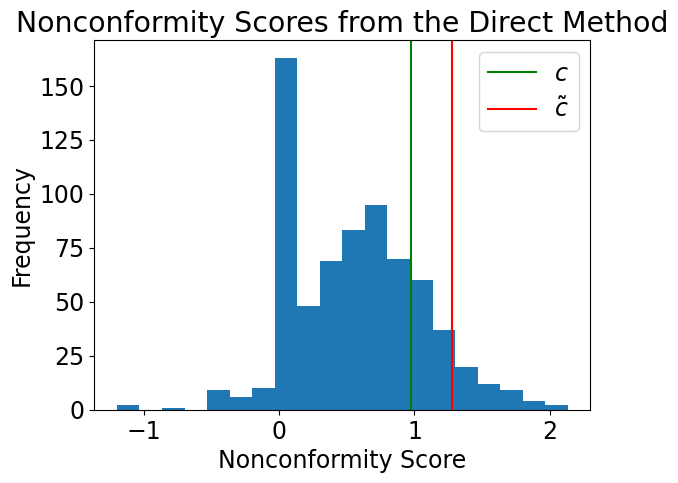

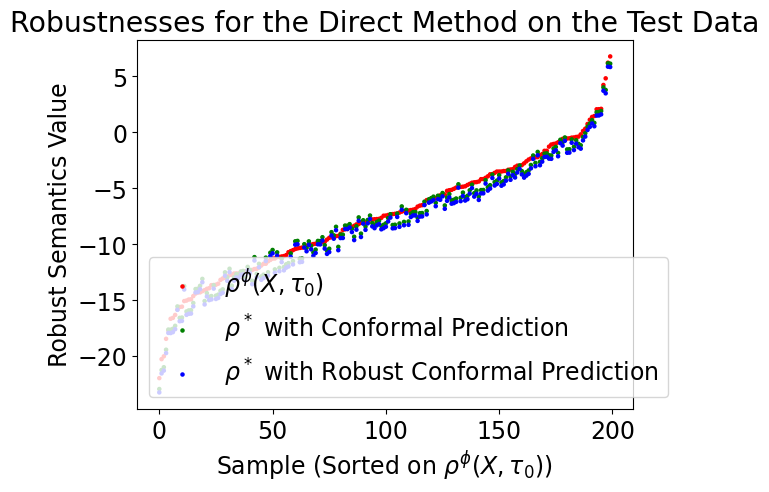

The Coverage of the Direct Method is:  0.745
The Coverage of the Robust Direct Method is: 0.875
Performing Experiment with the Indirect Method.


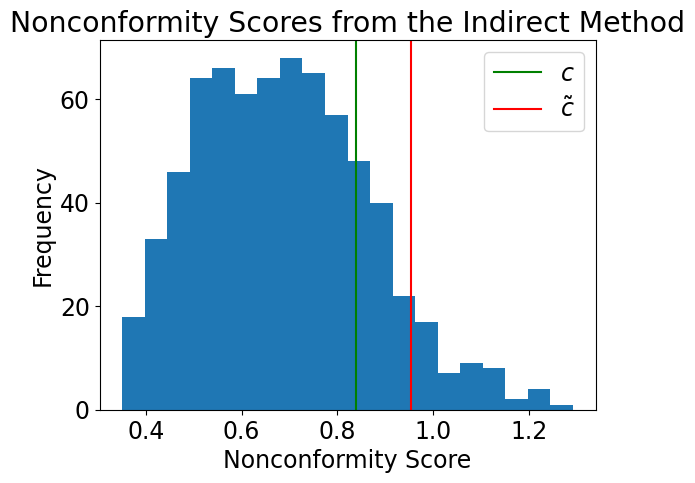

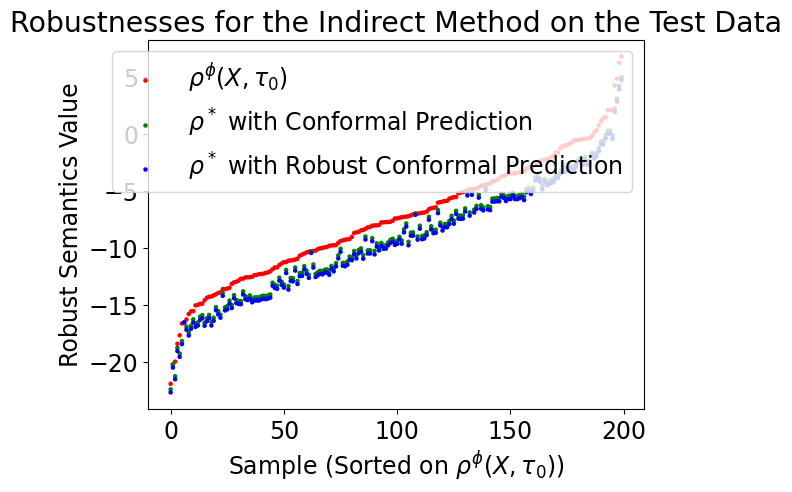

The Coverage of the Indirect Method is:  1.0
The Coverage of the Robust Indirect Method is:  1.0
Conducting Experiment  2
Performing Experiment with the Direct Method.
The Coverage of the Direct Method is:  0.69
The Coverage of the Robust Direct Method is: 0.835
Performing Experiment with the Indirect Method.
The Coverage of the Indirect Method is:  1.0
The Coverage of the Robust Indirect Method is:  1.0
Conducting Experiment  3
Performing Experiment with the Direct Method.
The Coverage of the Direct Method is:  0.785
The Coverage of the Robust Direct Method is: 0.93
Performing Experiment with the Indirect Method.
The Coverage of the Indirect Method is:  1.0
The Coverage of the Robust Indirect Method is:  1.0
Conducting Experiment  4
Performing Experiment with the Direct Method.
The Coverage of the Direct Method is:  0.69
The Coverage of the Robust Direct Method is: 0.825
Performing Experiment with the Indirect Method.
The Coverage of the Indirect Method is:  1.0
The Coverage of the Ro

In [6]:
experimental_size = 400
calibration_size = 700
test_size = 200
delta = 0.2

# These functions are for calculating delta_tilde
def f_divergence(t):
    # We assume to use the total variation distance.
    return 0.5 * abs(t - 1)


def g(f, epsilon, beta, search_step = 0.0007):
    # Check input.
    if beta < 0 or beta > 1:
        raise Exception("Input to the function g is out of range.")
    # Perform a sampling-based line search.
    z = 0
    while z <= 1:
        value = beta * f(z / beta) + (1 - beta) * f((1 - z) / (1 - beta))
        if value <= epsilon:
            return z
        z += search_step
    raise Exception("No return from function g.")


def g_inverse(f, epsilon, tau, search_step = 0.0007):
    # Check input.
    if tau < 0 or tau > 1:
        raise Exception("Input to the function g_inverse is out of range.")
    beta = 1
    while beta >= 0:
        if beta != 1 and g(f, epsilon, beta) <= tau:
            return beta
        beta -= search_step
    raise Exception("No return from function g_inverse.")


def calculate_delta_n(delta, n, f, epsilon):
    inner = (1 + 1 / n) * g_inverse(f, epsilon, 1 - delta)
    return (1 - g(f, epsilon, inner))


def calculate_delta_tilde(delta_n, f, epsilon):
    answer = 1 - g_inverse(f, epsilon, 1 - delta_n)
    return answer


# We also need a function in computing the worst-case semantics given a trajectory and the prediction regions.
def compute_worst_robust_semantics(alt, vel, prediction_regions):
    collision_robustnesses = []
    height_robustnesses = []
    speed_robustnesses = []
    for tau in range(0, terminal_time + 1):
        if tau <= current_time:
            collision_robustness = alt[tau] - zeta_1
            height_robustness = alt[tau] - zeta_2
            speed_robustness = zeta_3 - vel[tau]
        else:
            # Since the predicate is affine, the minimum predicate robustness happens only when the dimension of interest changes to the maximal amount while the other dimensions remain the same.
            collision_robustness = (alt[tau] - prediction_regions[tau]) - zeta_1
            height_robustness = (alt[tau] - prediction_regions[tau]) - zeta_2
            speed_robustness = zeta_3 - (vel[tau] + prediction_regions[tau])
        collision_robustnesses.append(collision_robustness)
        height_robustnesses.append(height_robustness)
        speed_robustnesses.append(speed_robustness)
    # Compose the robustnesses together.
    final_robustness = float("inf")
    for tau in range(len(alt)):
        time_robustness = min(collision_robustnesses[tau], max(height_robustnesses[tau], speed_robustnesses[tau]))
        final_robustness = min(final_robustness, time_robustness)
    return final_robustness


# Conduct the experiment.
direct_coverages = []
robust_direct_coverages = [] # This will include the coverages from the robust direct method.
indirect_coverages = []
robust_indirect_coverages = [] # This will include the coverages from the robust indirect method.

# Calculate delta_tilde.
delta_n = calculate_delta_n(delta, calibration_size, f_divergence, epsilon)
delta_tilde = calculate_delta_tilde(delta_n, f_divergence, epsilon)
print("Delta Tilde:", delta_tilde)

for i in range(experimental_size):
    print("Conducting Experiment ", i + 1)
    # First, collect the calibration data.
    calib_alts = []
    calib_vels = []
    for _ in range(calibration_size):
        altitude, velocity = plane.generate_nominal_trajectory(tmax, simulation_step)
        calib_alts.append(altitude)
        calib_vels.append(velocity)
    # Next, we generate predictions on the calibration data.
    calib_alts_prefixes = [calib_alts[j][:current_time + 1] for j in range(len(calib_alts))]
    calib_vels_prefixes = [calib_vels[j][:current_time + 1] for j in range(len(calib_vels))]
    calib_pred_alts, calib_pred_vels = generate_predictions(calib_alts_prefixes, calib_vels_prefixes, alt_predictor, vel_predictor, normalization)
    # Then, we generate the test set for each experiment.
    test_alts = []
    test_vels = []
    for _ in range(test_size):
        altitude, velocity = plane.generate_disturbed_trajectory(tmax, simulation_step) # Note here that we use the disturbed trajectories.
        test_alts.append(altitude)
        test_vels.append(velocity)
    # We generate the predictions on the test data (This is done online in validation, but we generate here to avoid redundant executions).
    test_alts_prefixes = [test_alts[j][:current_time + 1] for j in range(len(test_alts))]
    test_vels_prefixes = [test_vels[j][:current_time + 1] for j in range(len(test_vels))]
    test_pred_alts, test_pred_vels = generate_predictions(test_alts_prefixes, test_vels_prefixes, alt_predictor, vel_predictor, normalization)
    
    # Let's first experiment with the direct method.
    print("Performing Experiment with the Direct Method.")
    # Now, let's perform conformal prediction.
    calib_robustnesses = [compute_robust_semantics(calib_alts[j], calib_vels[j]) for j in range(calibration_size)]
    calib_pred_robustnesses = [compute_robust_semantics(calib_pred_alts[j], calib_pred_vels[j]) for j in range(calibration_size)]
    direct_nonconformity_scores = [calib_pred_robustnesses[j] - calib_robustnesses[j] for j in range(calibration_size)]
    direct_nonconformity_scores.sort()
    direct_nonconformity_scores.append(float("inf"))
    p = int(np.ceil((calibration_size + 1) * (1 - delta)))
    c_direct = direct_nonconformity_scores[p - 1]
    p_tilde = int(np.ceil(calibration_size * (1 - delta_tilde)))
    c_tilde_direct = direct_nonconformity_scores[p_tilde - 1]
    # We plot the histogram of nonconformity scores for illustration if this is the first trial.
    if i == 0:
        plt.hist(direct_nonconformity_scores[:-1], bins = 20)
        plt.xlabel("Nonconformity Score")
        plt.ylabel("Frequency")
        plt.axvline(c_direct, label = "$c$", color = "g")
        plt.axvline(c_tilde_direct, label = "$\\tilde{c}$", color = "r")
        plt.legend()
        plt.title("Nonconformity Scores from the Direct Method")
        plt.savefig("plots/nonconformity_scores_direct.pdf")
        plt.show()
        # Let's save the experimental results.
        with open("results/direct_nonconformity_scores.json" , "w") as file:
            json.dump(direct_nonconformity_scores, file)
        with open("results/c_direct.json", "w") as file:
            json.dump(c_direct, file)
        with open("results/c_tilde_direct.json", "w") as file:
            json.dump(c_tilde_direct, file)
    # Now, we are ready to validate the results.
    direct_correct_count = 0
    robust_direct_correct_count = 0
    direct_test_robustnesses = []
    direct_test_lowerbound_robustnesses = []
    robust_direct_test_lowerbound_robustnesses = []
    for j in range(test_size):
        direct_test_robustness = compute_robust_semantics(test_alts[j], test_vels[j])
        direct_test_pred_robustness = compute_robust_semantics(test_pred_alts[j], test_pred_vels[j])
        direct_test_lowerbound_robustness = direct_test_pred_robustness - c_direct
        robust_direct_test_lowerbound_robustness = direct_test_pred_robustness - c_tilde_direct
        if direct_test_robustness >= direct_test_lowerbound_robustness:
            direct_correct_count += 1
        if direct_test_robustness >= robust_direct_test_lowerbound_robustness:
            robust_direct_correct_count += 1
        direct_test_robustnesses.append(direct_test_robustness)
        direct_test_lowerbound_robustnesses.append(direct_test_lowerbound_robustness)
        robust_direct_test_lowerbound_robustnesses.append(robust_direct_test_lowerbound_robustness)
    # We plot the scatter plot of the robustnesses for testing.
    if i == 0:
        sorted_direct_test_robustnesses, sorted_direct_test_lowerbound_robustnesses, sorted_robust_direct_test_lowerbound_robustnesses= zip(*sorted(zip(direct_test_robustnesses, direct_test_lowerbound_robustnesses, robust_direct_test_lowerbound_robustnesses)))
        dot_sizes = [5 for j in range(test_size)]
        plt.scatter([j for j in range(test_size)], sorted_direct_test_robustnesses, s=dot_sizes, color = "r", label= "$\\rho^\phi(X, \\tau_0)$")
        plt.scatter([j for j in range(test_size)], sorted_direct_test_lowerbound_robustnesses , s=dot_sizes, color = "g", label= "$\\rho^*$ with Conformal Prediction")
        plt.scatter([j for j in range(test_size)], sorted_robust_direct_test_lowerbound_robustnesses , s=dot_sizes, color = "b", label= "$\\rho^*$ with Robust Conformal Prediction")
        plt.xlabel("Sample (Sorted on $\\rho^\phi(X, \\tau_0)$)")
        plt.ylabel("Robust Semantics Value")
        plt.legend()
        plt.title("Robustnesses for the Direct Method on the Test Data")
        plt.savefig("plots/direct_robustnesses_scatter.pdf")
        plt.show()
        # Save the experimental results.
        with open("results/direct_test_robustnesses.json", "w") as file:
            json.dump(direct_test_robustnesses, file)
        with open("results/direct_test_lowerbound_robustnesses.json", "w") as file:
            json.dump(direct_test_lowerbound_robustnesses, file)
        with open("results/robust_direct_test_lowerbound_robustnesses.json", "w") as file:
            json.dump(robust_direct_test_lowerbound_robustnesses, file)
    direct_coverage = direct_correct_count / test_size
    robust_direct_coverage = robust_direct_correct_count / test_size
    direct_coverages.append(direct_coverage)
    robust_direct_coverages.append(robust_direct_coverage)
    print("The Coverage of the Direct Method is: ", direct_coverage)
    print("The Coverage of the Robust Direct Method is:", robust_direct_coverage)
    
    # Let's now conduct an experiment with the indirect method with both union bound and normalization.
    print("Performing Experiment with the Indirect Method.")
    # Now, let's perform conformal prediction.
    indirect_nonconformity_scores = []
    for j in range(calibration_size):
        max_score = 0 - float("inf")
        for tau in range(current_time + 1, terminal_time + 1):
            ground_alt = calib_alts[j][tau]
            pred_alt = calib_pred_alts[j][tau]
            ground_vel = calib_vels[j][tau]
            pred_vel = calib_pred_vels[j][tau]
            error = ((ground_alt - pred_alt) ** 2 + (ground_vel - pred_vel) ** 2) ** (1 / 2)
            max_score = max(max_score, alphas[tau] * error)
        indirect_nonconformity_scores.append(max_score)
    indirect_nonconformity_scores.sort()
    indirect_nonconformity_scores.append(float("inf"))
    p = int(np.ceil((calibration_size + 1) * (1 - delta)))
    c_indirect = indirect_nonconformity_scores[p - 1]
    p_tilde = int(np.ceil(calibration_size * (1 - delta_tilde)))
    c_tilde_indirect = indirect_nonconformity_scores[p_tilde - 1]
    # Let's illustrate one example of nonconformity scores.
    if i == 0:
        plt.hist(indirect_nonconformity_scores[:-1], bins = 20)
        plt.xlabel("Nonconformity Score")
        plt.ylabel("Frequency")
        plt.axvline(c_indirect, label = "$c$", color = "g")
        plt.axvline(c_tilde_indirect, label = "$\\tilde{c}$", color = "r")
        plt.legend()
        plt.title("Nonconformity Scores from the Indirect Method")
        plt.savefig("plots/nonconformity_scores_indirect.pdf")
        plt.show()
        # Let's save the experimental results.
        with open("results/indirect_nonconformity_scores.json" , "w") as file:
            json.dump(indirect_nonconformity_scores, file)
        with open("results/c_indirect.json", "w") as file:
            json.dump(c_indirect, file)
        with open("results/c_tilde_indirect.json", "w") as file:
            json.dump(c_tilde_indirect, file)
    # Compute prediction regions.
    prediction_regions = dict()
    for tau in range(current_time + 1, terminal_time + 1):
        prediction_regions[tau] = c_indirect / alphas[tau]
    robust_prediction_regions = dict()
    for tau in range(current_time + 1, terminal_time + 1):
        robust_prediction_regions[tau] = c_tilde_indirect / alphas[tau]
    # Now, we are ready to validate the results.
    indirect_correct_count = 0
    robust_indirect_correct_count = 0
    indirect_test_robustnesses = []
    indirect_test_lowerbound_robustnesses = []
    robust_indirect_test_lowerbound_robustnesses = []
    for j in range(test_size):
        indirect_test_robustness = compute_robust_semantics(test_alts[j], test_vels[j])
        # We now call the previously written function for the worst-case semantics.
        indirect_test_lowerbound_robustness = compute_worst_robust_semantics(test_alts[j], test_vels[j], prediction_regions)
        robust_indirect_test_lowerbound_robustness = compute_worst_robust_semantics(test_alts[j], test_vels[j], robust_prediction_regions)
        if indirect_test_robustness >= indirect_test_lowerbound_robustness:
            indirect_correct_count += 1
        if indirect_test_robustness >= robust_indirect_test_lowerbound_robustness:
            robust_indirect_correct_count += 1
        indirect_test_robustnesses.append(indirect_test_robustness)
        indirect_test_lowerbound_robustnesses.append(indirect_test_lowerbound_robustness)
        robust_indirect_test_lowerbound_robustnesses.append(robust_indirect_test_lowerbound_robustness)
    # We plot the scatter plot of the robustnesses for testing.
    if i == 0:
        sorted_indirect_test_robustnesses, sorted_indirect_test_lowerbound_robustnesses, sorted_robust_indirect_test_lowerbound_robustnesses = zip(*sorted(zip(indirect_test_robustnesses, indirect_test_lowerbound_robustnesses, robust_indirect_test_lowerbound_robustnesses)))
        dot_sizes = [5 for j in range(test_size)]
        plt.scatter([j for j in range(test_size)], sorted_indirect_test_robustnesses, s=dot_sizes, color = "r", label= "$\\rho^\phi(X, \\tau_0)$")
        plt.scatter([j for j in range(test_size)], sorted_indirect_test_lowerbound_robustnesses , s=dot_sizes, color = "g", label= "$\\rho^*$ with Conformal Prediction")
        plt.scatter([j for j in range(test_size)], sorted_robust_indirect_test_lowerbound_robustnesses , s=dot_sizes, color = "b", label= "$\\rho^*$ with Robust Conformal Prediction")
        plt.xlabel("Sample (Sorted on $\\rho^\phi(X, \\tau_0)$)")
        plt.ylabel("Robust Semantics Value")
        plt.legend()
        plt.title("Robustnesses for the Indirect Method on the Test Data")
        plt.savefig("plots/indirect_robustnesses_scatter.pdf")
        plt.show()
        # Save the experimental results.
        with open("results/indirect_test_robustnesses.json", "w") as file:
            json.dump(indirect_test_robustnesses, file)
        with open("results/indirect_test_lowerbound_robustnesses.json", "w") as file:
            json.dump(indirect_test_lowerbound_robustnesses, file)
        with open("results/robust_indirect_test_lowerbound_robustnesses.json", "w") as file:
            json.dump(robust_indirect_test_lowerbound_robustnesses, file)
    indirect_coverage = indirect_correct_count / test_size
    robust_indirect_coverage = robust_indirect_correct_count / test_size
    indirect_coverages.append(indirect_coverage)
    robust_indirect_coverages.append(robust_indirect_coverage)
    print("The Coverage of the Indirect Method is: ", indirect_coverage)
    print("The Coverage of the Robust Indirect Method is: ", robust_indirect_coverage)

# Save the coverages.
with open("results/direct_coverages.json", "w") as file:
    json.dump(direct_coverages, file)
with open("results/robust_direct_coverages.json", "w") as file:
    json.dump(robust_direct_coverages, file)
with open("results/indirect_coverages.json", "w") as file:
    json.dump(indirect_coverages, file)
with open("results/robust_indirect_coverages.json", "w") as file:
    json.dump(robust_indirect_coverages, file)

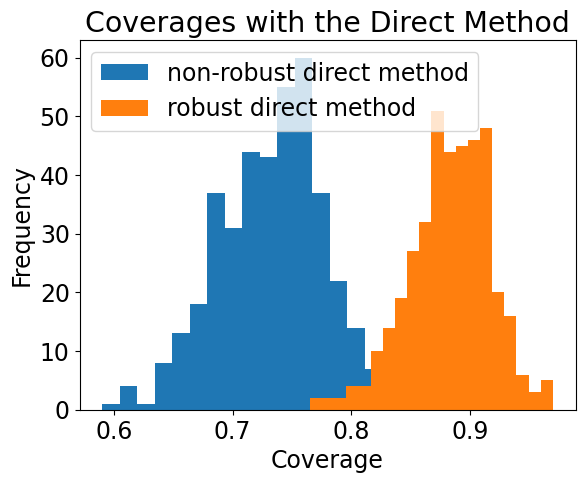

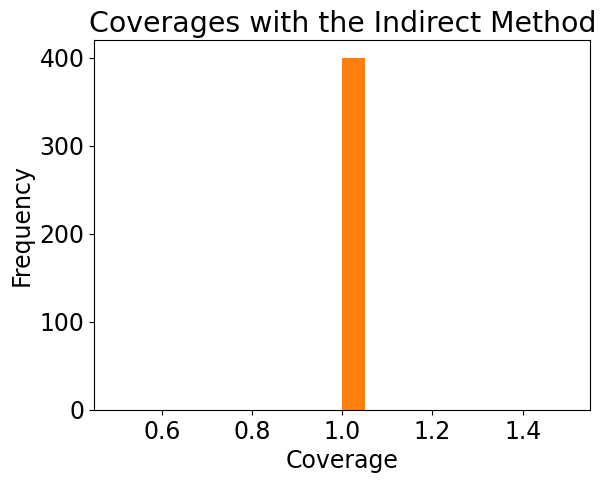

In [7]:
plt.hist(direct_coverages, bins = 20, label = "non-robust direct method")
plt.hist(robust_direct_coverages, bins = 20, label = "robust direct method")
plt.title("Coverages with the Direct Method")
plt.xlabel("Coverage")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("plots/direct_coverages.pdf")
plt.show()

plt.hist(indirect_coverages, bins = 20, label = "non-robust indirect method")
plt.hist(robust_indirect_coverages, bins = 20, label = "robust indirect method")
plt.title("Coverages with the Indirect Method")
plt.xlabel("Coverage")
plt.ylabel("Frequency")
plt.savefig("plots/indirect_coverages.pdf")
plt.show()